In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
BASE_DIR = '../../Data/S_Data'
geolocation_path = os.path.join(BASE_DIR, 'geolocation.csv')
order_items_path = os.path.join(BASE_DIR, 'order_items.csv')
order_payments_path = os.path.join(BASE_DIR, 'order_payments.csv')
order_reviews_path = os.path.join(BASE_DIR, 'order_reviews.csv')
orders_path = os.path.join(BASE_DIR, 'orders.csv')
products_path = os.path.join(BASE_DIR, 'products.csv')
sellers_path = os.path.join(BASE_DIR, 'sellers.csv')

In [3]:
order_items_df = pd.read_csv(order_items_path) # ../../Data/S_Data/order_items.csv
orders_df = pd.read_csv(orders_path)

------------------------------------------------------

In [4]:
merged_df = pd.merge(order_items_df, orders_df, how='left', on='order_id')

merged_df = merged_df.set_index('order_purchase_timestamp')
merged_df.index = pd.to_datetime(merged_df.index)
merged_df.index.name = 'date'
merged_df['items'] = merged_df.groupby('order_id')['order_item_id'].transform('count')
merged_df.head(2)

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,customer_id,order_status,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,items
date,,,,,,,,,,,,,,
2017-09-13 08:59:02,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.9,13.29,3ce436f183e68e07877b285a838db11a,delivered,2017-09-13 09:45:35,2017-09-19 18:34:16,2017-09-20 23:43:48,2017-09-29 00:00:00,1
2017-04-26 10:53:06,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.9,19.93,f6dd3ec061db4e3987629fe6b26e5cce,delivered,2017-04-26 11:05:13,2017-05-04 14:35:00,2017-05-12 16:04:24,2017-05-15 00:00:00,1


<Axes: xlabel='date'>

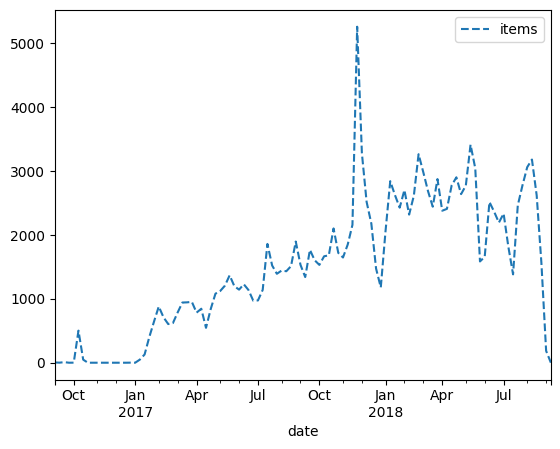

In [5]:
weekly_items_df = merged_df.resample('W').sum()[['items']]
weekly_items_df.plot(style='--')

<Axes: xlabel='date'>

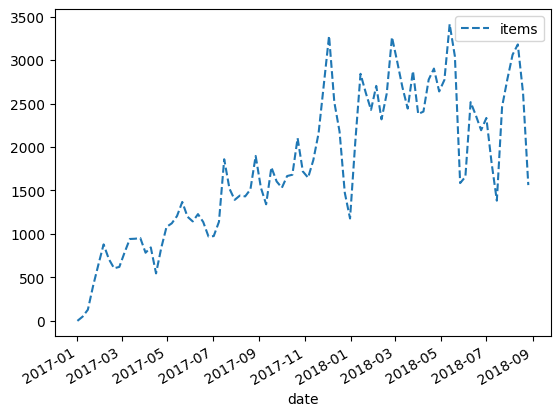

In [6]:
weekly_items_df = weekly_items_df.loc[weekly_items_df.index >= '2017-01-01']
weekly_items_df = weekly_items_df.loc[weekly_items_df.index <= '2018-09-01']
weekly_items_df = weekly_items_df.query('items < 4000').copy()
weekly_items_df.plot(style='--')

<Axes: ylabel='Frequency'>

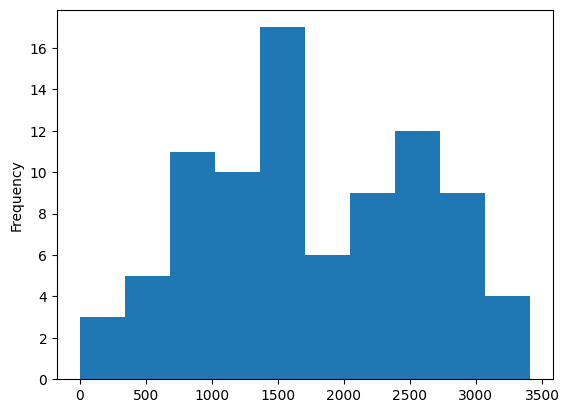

In [7]:
weekly_items_df['items'].plot(kind='hist')

In [8]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

weekly_items_df = create_features(weekly_items_df)
weekly_items_df

,items,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
date,,,,,,,,,
2017-01-01,0,0,6,1,1,2017,1,1,52
2017-01-08,49,0,6,1,1,2017,8,8,1
2017-01-15,129,0,6,1,1,2017,15,15,2
2017-01-22,403,0,6,1,1,2017,22,22,3
2017-01-29,646,0,6,1,1,2017,29,29,4
...,...,...,...,...,...,...,...,...,...
2018-07-29,2778,0,6,3,7,2018,210,29,30
2018-08-05,3061,0,6,3,8,2018,217,5,31
2018-08-12,3180,0,6,3,8,2018,224,12,32


In [9]:
def add_lags(df):
    target_map = df['items'].to_dict()
    df['lag1'] = (df.index - pd.Timedelta('4W')).map(target_map)
    df['lag2'] = (df.index - pd.Timedelta('8W')).map(target_map)
    df['lag3'] = (df.index - pd.Timedelta('12W')).map(target_map)
    return df

weekly_items_df = add_lags(weekly_items_df)
weekly_items_df.tail()

,items,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,lag1,lag2,lag3
date,,,,,,,,,,,,
2018-07-29,2778,0,6,3,7,2018,210,29,30,2334.0,1658.0,2772.0
2018-08-05,3061,0,6,3,8,2018,217,5,31,1817.0,2516.0,3413.0
2018-08-12,3180,0,6,3,8,2018,224,12,32,1383.0,2363.0,3042.0
2018-08-19,2620,0,6,3,8,2018,231,19,33,2463.0,2193.0,1585.0
2018-08-26,1562,0,6,3,8,2018,238,26,34,2778.0,2334.0,1658.0


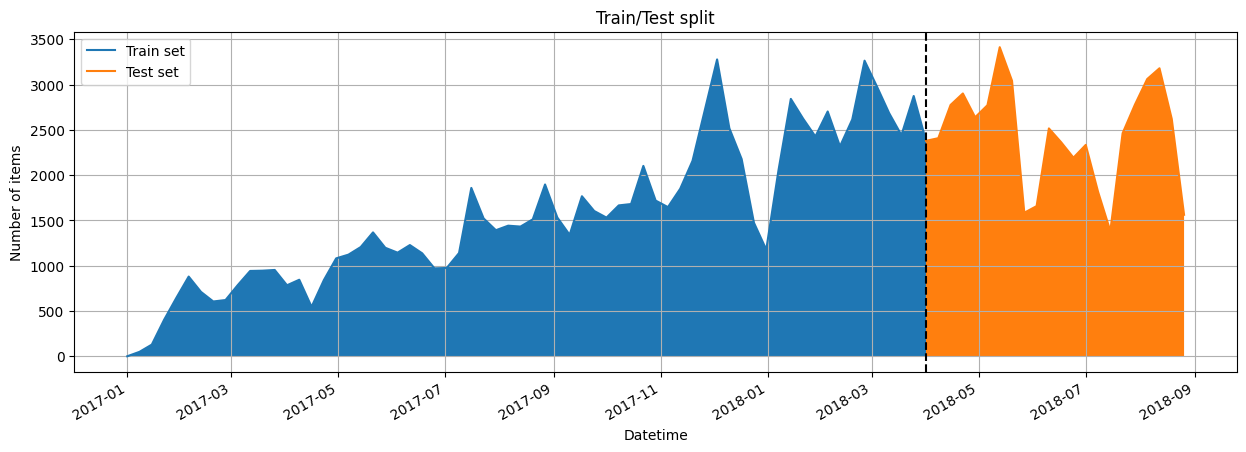

In [10]:

fig, ax = plt.subplots(sharex=True, figsize=(15, 5))
train = weekly_items_df.loc[weekly_items_df.index <= '2018-04-01']
test = weekly_items_df.loc[weekly_items_df.index >= '2018-04-01']
train['items'].plot(ax=ax)
test['items'].plot(ax=ax)
ax.fill_between(train.index, train['items'])
ax.fill_between(test.index, test['items'])
ax.axvline('2018-04-01', ls='--', color='black')
plt.legend(['Train set', 'Test set'])
plt.title('Train/Test split')
plt.ylabel('Number of items')
plt.xlabel('Datetime')
plt.grid(True)
plt.show()

In [11]:
FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month','year', 'lag1', 'lag2', 'lag3']
TARGET = 'items'

X_train, y_train = train[FEATURES], train[TARGET]
X_test, y_test = test[FEATURES], test[TARGET]

In [12]:
import xgboost as xgb

reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)

reg.fit(X_train, y_train, 
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[0]	validation_0-rmse:1707.44627	validation_1-rmse:2487.03987
[100]	validation_0-rmse:721.41271	validation_1-rmse:1280.50583
[200]	validation_0-rmse:347.13921	validation_1-rmse:798.68094


/home/hamuladm/.local/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [03:04:58] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[300]	validation_0-rmse:205.31046	validation_1-rmse:627.98064
[400]	validation_0-rmse:149.33382	validation_1-rmse:589.50180
[500]	validation_0-rmse:121.83422	validation_1-rmse:582.04787
[600]	validation_0-rmse:104.48212	validation_1-rmse:580.65679
[643]	validation_0-rmse:97.91809	validation_1-rmse:581.17466


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, objective='reg:linear', ...)

In [13]:
y_pred = reg.predict(X_test)

<Axes: xlabel='date'>

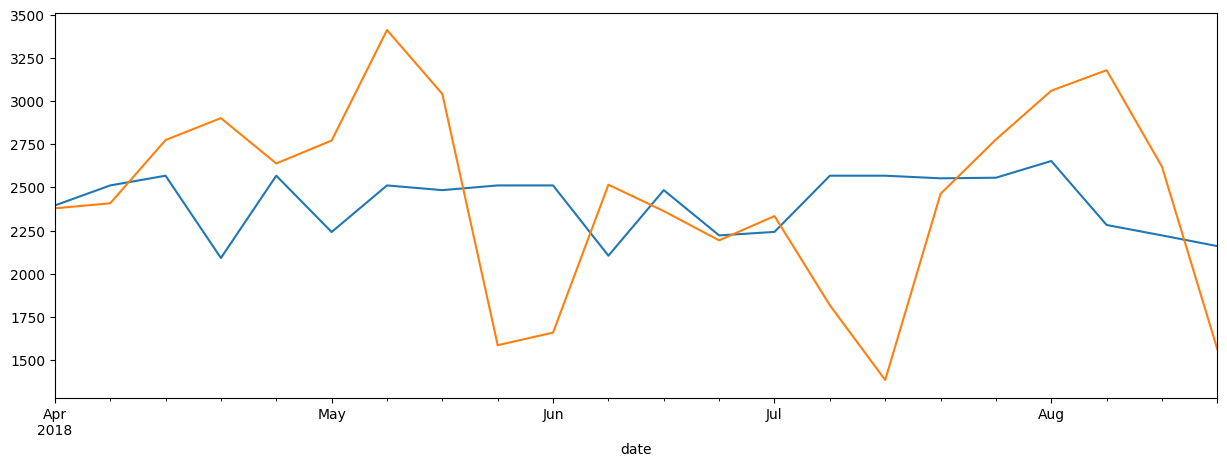

In [22]:
y_pred = pd.Series(y_pred)
df = pd.DataFrame(y_test.values, columns=['True Values'])
df['Predicted Values'] = y_pred.values
df.index = y_test.index

fig, ax = plt.subplots(sharex=True, figsize=(15,5))

df['Predicted Values'].plot(ax=ax)
df['True Values'].plot(ax=ax)
